# INTRODUCTION

Code produced by Zainab Akhtar

**Imports**

In [58]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, LSTM, Dropout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Preperation for LSTM

---
Code adapted from: https://github.com/aqibsaeed/Entity-Embedding-with-LSTM-for-Time-Series

In [8]:
# Load data into a Pandas data frame.
file_path = '../data/final_dataset_aggregated.csv'
data = pd.read_csv(file_path)


# Convert 'Date' and 'Time' columns to datetime
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H:%M:%S')

# Extract date and time features
data['Month'] = data['DateTime'].dt.month
data['Day'] = data['DateTime'].dt.day
data['Hour'] = data['DateTime'].dt.hour

# # Filter the DataFrame based on the date range
start_date = '2023-03-16'
end_date = '2023-11-07'
data = data[(data['DateTime'] >= start_date) & (data['DateTime'] <= end_date)]

# Drop original 'Date' and 'Time' columns
data.drop(['Date', 'Time', 'DateTime','Outdoor Temperature_mean','Outdoor Temperature_min','Outdoor Temperature_max','Classroom Category','Device Code','Measured RH_min','Measured RH_mean','Measured RH_max','Measured CO2_min','Measured CO2_mean','Measured CO2_max','Measured PM1.0_min','Measured PM1.0_mean','Measured PM1.0_max','Measured PM2.5_min','Measured PM2.5_mean','Measured PM2.5_max','Measured PM10_min','Measured PM10_mean','Measured PM10_max','Grade','Room No','BattV_Min_min','BattV_Min_mean','BattV_Min_max','Batt24V_Min_min','Batt24V_Min_mean','Batt24V_Min_max','School No','Tracker2WM_Avg_min','Tracker2WM_Avg_mean','Tracker2WM_Avg_max'], axis=1, inplace=True)

# Fill all the null values using forward fill method
data.ffill(inplace=True)
data.isnull().sum()    


Classroom Type           0
Measured T_mean          0
Measured T_min           0
Measured T_max           0
School Day               0
School Hours             0
Break Time               0
Power On                 0
TmStamp                  0
TrackerWM_Avg_mean       0
TrackerWM_Avg_min        0
TrackerWM_Avg_max        0
ShadowWM_Avg_mean        0
ShadowWM_Avg_min         0
ShadowWM_Avg_max         0
SunWM_Avg_mean           0
SunWM_Avg_min            0
SunWM_Avg_max            0
ShadowbandWM_Avg_mean    0
ShadowbandWM_Avg_min     0
ShadowbandWM_Avg_max     0
DNICalc_Avg_mean         0
DNICalc_Avg_min          0
DNICalc_Avg_max          0
AirTC_Avg_mean           0
AirTC_Avg_min            0
AirTC_Avg_max            0
RH_mean                  0
RH_min                   0
RH_max                   0
WS_ms_S_WVT_mean         0
WS_ms_S_WVT_min          0
WS_ms_S_WVT_max          0
WindDir_D1_WVT_mean      0
WindDir_D1_WVT_min       0
WindDir_D1_WVT_max       0
WindDir_SD1_WVT_mean     0
W

In [9]:
def preprocess_categorical(x_train, x_test, categorical):
    # Initialize a dictionary to hold the label encoders for each categorical feature
    label_encoders = {}

    # Columns to be embedded: map to range [0, # values)
    for cat in categorical:
        le = LabelEncoder()
        # Fit the label encoder on the training data and transform both train and test data
        x_train[cat] = le.fit_transform(x_train[cat])
        x_test[cat] = le.fit_transform(x_test[cat])
        # # Store the label encoder for future use if needed
        # label_encoders[cat] = le

    return x_train, x_test

def prepare_data(x, y, categorical, numeric, steps):
    _x, _y = [], []
    columns = categorical + numeric
    for col in columns:
        inp = []
        for i in range(len(x) - steps): 
            v = x.iloc[i:(i + steps)][col].values.astype(np.float32)
            if col in numeric: 
                v = v.reshape(steps, 1)
            inp.append(v)
        inp = np.stack(inp, axis = 0)
        _x.append(inp)   
        
    for i in range(len(x) - steps): 
      _y.append(y.iloc[i + steps].values)
    _y = np.array(_y).astype(np.float32)
    
    return _x, _y

In [13]:
def preprocess_categorical(data, categorical):
    for cat in categorical:
        le = LabelEncoder()
        data[cat] = le.fit_transform(data[cat])

    return data

In [15]:
# input_cols = ['Classroom Type', 'School Day', 'School Hours', 'Break Time', 'Power On',  'Month', 'Day', 'Hour',
#               'TrackerWM_Avg_mean','ShadowWM_Avg_mean','SunWM_Avg_mean', 'ShadowbandWM_Avg_mean', 'DNICalc_Avg_mean','AirTC_Avg_mean','RH_mean', 'WS_ms_S_WVT_mean','WindDir_D1_WVT_mean', 'WindDir_SD1_WVT_mean', 'BP_mB_Avg_mean', 'UVA_Avg_mean','UVB_Avg_mean'
# ]
# target_col = 'Measured T_mean'

date_time = ['Month','Day', 'Hour']
numeric = ['TrackerWM_Avg_mean','ShadowWM_Avg_mean','SunWM_Avg_mean', 'ShadowbandWM_Avg_mean', 'DNICalc_Avg_mean','AirTC_Avg_mean','RH_mean', 'WS_ms_S_WVT_mean','WindDir_D1_WVT_mean', 'WindDir_SD1_WVT_mean', 'BP_mB_Avg_mean', 'UVA_Avg_mean','UVB_Avg_mean']
categorical = ['Classroom Type', 'School Day', 'School Hours', 'Break Time', 'Power On']
label = ['Measured T_mean']

#1) Encoding
data = preprocess_categorical(data, categorical)

#2) Train-Test Split
data = data.sort_values(by='TmStamp')
train_percent = 0.8       # percentage of data for training, rest will be for testing
train_split = int(len(data)*train_percent)
train = data[:train_split] # training dataset
test  = data[train_split:]   # testing dataset

# Separate features and label
train_x = train[categorical + numeric + date_time]
train_y = train[['Measured T_mean']]

test_x = test[categorical + numeric + date_time]
test_y = test[['Measured T_mean']]

#3) Feature Scaling Needed for LSTMs
num_scalers = {}
for num in numeric:
    scaler =  MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_x[num].values.reshape(-1, 1))
    train_x.iloc[:][num] = scaler.transform(
        train_x.iloc[:][num].values.reshape(-1, 1))
    test_x.iloc[:][num] = scaler.transform(
        test_x.iloc[:][num].values.reshape(-1, 1))
    num_scalers[num] = scaler

y_scaler =  MinMaxScaler()
y_scaler.fit(train_y.values.reshape(-1, 1))
train_y.iloc[:][label] = y_scaler.transform(train_y.values.reshape(-1, 1))
test_y.iloc[:][label] = y_scaler.transform(test_y.values.reshape(-1, 1))

/var/folders/sr/cf_jdmpx78952kg9qz2tkjqh0000gn/T/ipykernel_87787/3916657602.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_x.iloc[:][num] = scaler.transform(
/var/folders/sr/cf_jdmpx78952kg9qz2tkjqh0000gn/T/ipykernel_87787/391665

In [18]:
steps = 1 # hyper-parameter: window size
train_x, train_y = prepare_data(train_x, train_y, categorical, numeric, steps)
test_x, test_y = prepare_data(test_x, test_y, categorical, numeric, steps)

Epoch 1/30


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


935/935 - 3s - 3ms/step - loss: 45.6315 - val_loss: 10.8763
Epoch 2/30
935/935 - 1s - 1ms/step - loss: 9.6139 - val_loss: 7.9817
Epoch 3/30
935/935 - 1s - 1ms/step - loss: 7.4418 - val_loss: 7.2934
Epoch 4/30
935/935 - 1s - 1ms/step - loss: 6.7222 - val_loss: 7.0565
Epoch 5/30
935/935 - 1s - 1ms/step - loss: 6.5397 - val_loss: 8.6869
Epoch 6/30
935/935 - 1s - 1ms/step - loss: 6.4282 - val_loss: 7.0130
Epoch 7/30
935/935 - 1s - 1ms/step - loss: 6.3316 - val_loss: 6.7221
Epoch 8/30
935/935 - 1s - 1ms/step - loss: 6.2223 - val_loss: 6.8702
Epoch 9/30
935/935 - 1s - 1ms/step - loss: 6.2328 - val_loss: 7.8722
Epoch 10/30
935/935 - 1s - 1ms/step - loss: 6.1617 - val_loss: 6.8780
Epoch 11/30
935/935 - 1s - 1ms/step - loss: 6.1435 - val_loss: 6.9405
Epoch 12/30
935/935 - 1s - 1ms/step - loss: 6.1388 - val_loss: 6.6475
Epoch 13/30
935/935 - 1s - 1ms/step - loss: 6.1453 - val_loss: 6.8485
Epoch 14/30
935/935 - 1s - 1ms/step - loss: 6.0855 - val_loss: 6.6292
Epoch 15/30
935/935 - 1s - 1ms/step - 

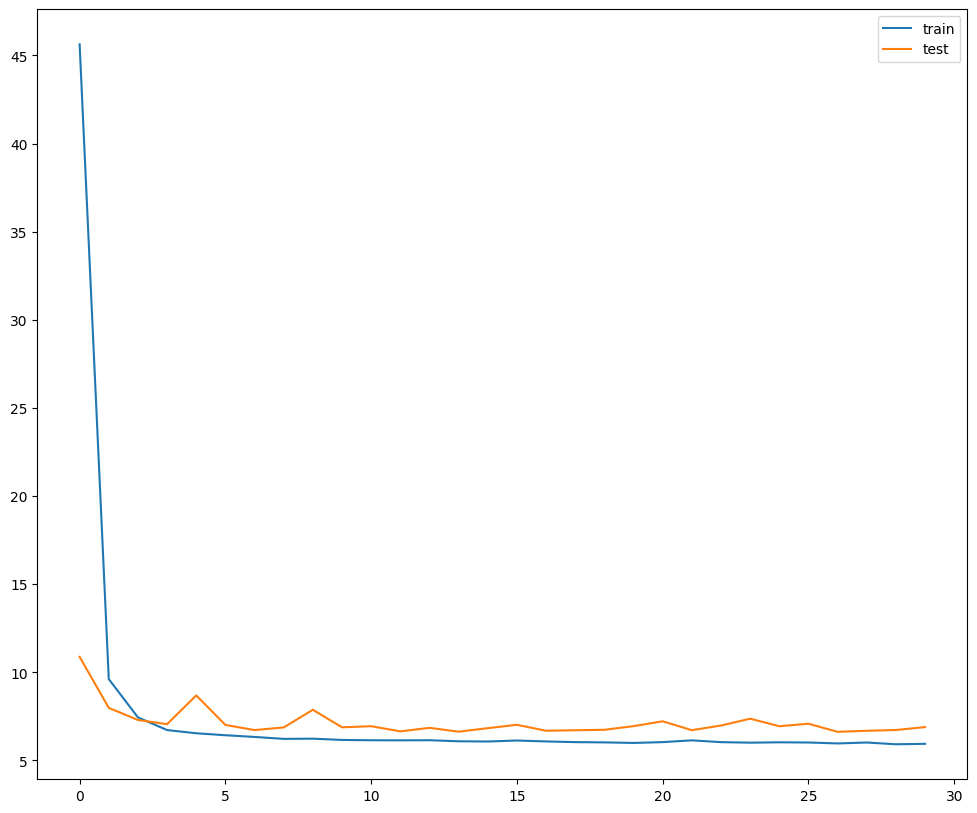

In [45]:
inputs, embeddings = [], []

for cat in categorical:
    cat_input = Input(shape=(steps,), name="".join([cat.replace(" ", ""),"_inp"]))
    unique_cat  = train[cat].nunique()
    embedding_size = min(np.ceil((unique_cat)/2), 20)
    embedding_size = int(embedding_size)
    cat_dim = unique_cat + 1
    inputs.append(cat_input)
    embeddings.append(Embedding(cat_dim, embedding_size, input_length = steps,
            name="".join([cat.replace(" ", ""),"_emb"]))(cat_input))
for num in numeric:
    num_input = Input(shape=(steps,1), 
          name="".join([num.replace(" ", ""),"_inp"]))
    inputs.append(num_input)
    embeddings.append(num_input)
    
x = Concatenate(name="concat")(embeddings)
x = LSTM(128, kernel_regularizer=l2(0.0001), 
        recurrent_regularizer=l2(0.0001),
        return_sequences=False)(x)
x = Dense(64, activation="relu", kernel_regularizer=l2(0.0001))(x)
out = Dense(1, activation='linear', name="output")(x)
model = Model(inputs, out, name = "so2_model")
model.compile(optimizer = Adam(learning_rate = 3e-4), loss=MeanSquaredError())
history = model.fit(train_x, train_y, epochs = 30, batch_size = 24, verbose = 2, validation_data=(test_x, test_y))

# Plot Model Loss

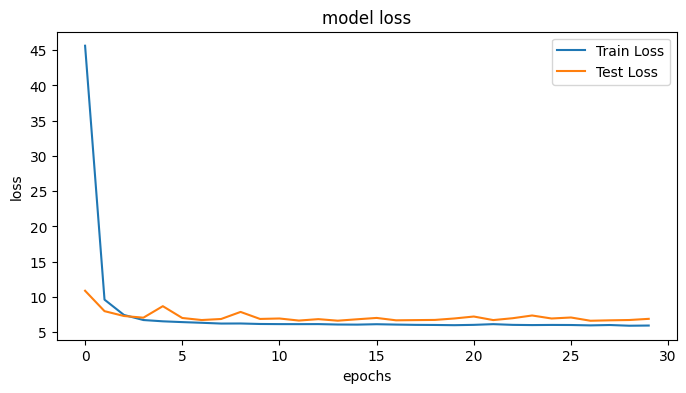

In [47]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

# Make Predictions

In [55]:
pred_y = model.predict(train_x)
train_mse = mean_squared_error(y_scaler.inverse_transform(train_y), 
                y_scaler.inverse_transform(pred_y), squared = False)

print("Train RMSE: ", train_mse)

pred_y = model.predict(test_x)
test_mse = mean_squared_error(y_scaler.inverse_transform(test_y), 
                y_scaler.inverse_transform(pred_y), squared = False)
print("Test RMSE: ", test_mse)

701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step
Train RMSE:  70.086
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
Test RMSE:  75.05372


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [70]:
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)
# invert predictions
train_predict = y_scaler.inverse_transform(train_predict)
Y_train = y_scaler.inverse_transform(train_y)
test_predict = y_scaler.inverse_transform(test_predict)
Y_test = y_scaler.inverse_transform(test_y)
print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
Train Mean Absolute Error: 56.871254
Train Root Mean Squared Error: 70.086
Test Mean Absolute Error: 59.960617
Test Root Mean Squared Error: 75.05372


In [64]:
Y_train[0]

array([553.05914], dtype=float32)

In [59]:
# Make predictions on the training set
pred_train_y = model.predict(train_x)
train_rmse = mean_squared_error(y_scaler.inverse_transform(train_y), 
                                y_scaler.inverse_transform(pred_train_y), squared=False)
train_mse = mean_squared_error(y_scaler.inverse_transform(train_y), 
                               y_scaler.inverse_transform(pred_train_y))
train_mae = mean_absolute_error(y_scaler.inverse_transform(train_y), 
                                y_scaler.inverse_transform(pred_train_y))
train_r2 = r2_score(y_scaler.inverse_transform(train_y), 
                    y_scaler.inverse_transform(pred_train_y))

print("Train RMSE: ", train_rmse)
print("Train MSE: ", train_mse)
print("Train MAE: ", train_mae)
print("Train R2: ", train_r2)

# Make predictions on the test set
pred_test_y = model.predict(test_x)
test_rmse = mean_squared_error(y_scaler.inverse_transform(test_y), 
                               y_scaler.inverse_transform(pred_test_y), squared=False)
test_mse = mean_squared_error(y_scaler.inverse_transform(test_y), 
                              y_scaler.inverse_transform(pred_test_y))
test_mae = mean_absolute_error(y_scaler.inverse_transform(test_y), 
                               y_scaler.inverse_transform(pred_test_y))
test_r2 = r2_score(y_scaler.inverse_transform(test_y), 
                   y_scaler.inverse_transform(pred_test_y))

print("Test RMSE: ", test_rmse)
print("Test MSE: ", test_mse)
print("Test MAE: ", test_mae)
print("Test R2: ", test_r2)

701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step
Train RMSE:  70.086
Train MSE:  4912.047
Train MAE:  56.871254
Train R2:  0.6328717470169067
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
Test RMSE:  75.05372
Test MSE:  5633.0605
Test MAE:  59.960617
Test R2:  0.5610811710357666


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Compare Actual vs. Prediction

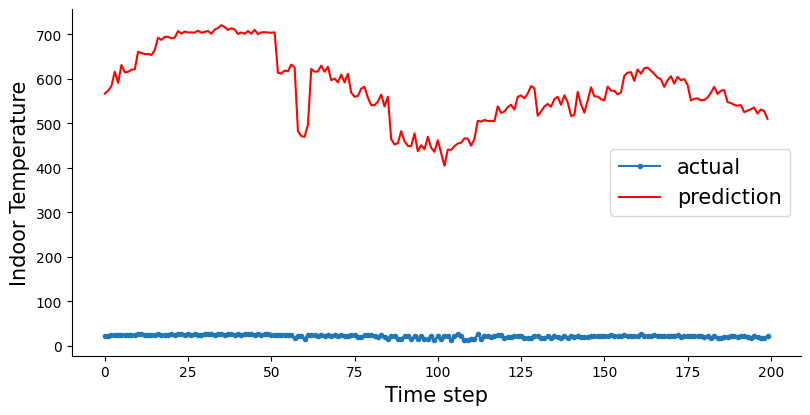

In [72]:
import seaborn as sns
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, test_y[:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Indoor Temperature', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();